## **CNN Model**

1.1 Import essential libraries for this model.

In [3]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models import ResNet, resnet50
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

# TensorFlow
from tensorflow.keras.models import Model
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tabulate import tabulate

1.2 Unpickle the data files.

In [5]:
def unpickle(file): # unpickle a file and return the dictionary contained within it.
    import pickle
    with open(file, 'rb') as fo: # opening the file in binary read mode.
        dict = pickle.load(fo, encoding='bytes')
    return dict # returning the loaded dictionary.

1.3 Standard Deviation Calculation: Calculate the standard deviation value for each channel across all training images.

In [7]:
# Define the transform without normalization.
transform_no_normalization = transforms.Compose([
    transforms.ToTensor()
])

# Load the CIFAR-10 training dataset without normalization.
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_no_normalization)

# Initialize lists to store channel-wise mean and standard deviation.
mean = [0, 0, 0] # initialize mean for RGB channels.
std = [0, 0, 0] # initialize standard deviation for RGB channels.

# Calculate mean and standard deviation for each channel.
for images, _ in train_dataset:
    for i in range(3):  # iterate over RGB channels.
        mean[i] += images[i, :, :].mean()
        std[i] += images[i, :, :].std()

# Calculate the mean and standard deviation for the entire dataset.
mean = [m / len(train_dataset) for m in mean] # divide by the number of images to get the average mean.
std = [s / len(train_dataset) for s in std] # divide by the number of images to get the average standard deviation.

# Print the final outcome.
print("Mean:", mean)
print("Standard Deviation:", std)

100%|██████████| 170498071/170498071 [00:25<00:00, 6631080.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean: [tensor(0.4914), tensor(0.4822), tensor(0.4465)]
Standard Deviation: [tensor(0.2023), tensor(0.1994), tensor(0.2010)]


1.4 Prepare and load the CIFAR-10 dataset for both training and testing purposes.

In [9]:
# Define transformations for training and testing sets.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((mean), (std)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(), # convert the image to a PyTorch tensor.
    transforms.Normalize((mean), (std)),
])

# Load CIFAR-10 dataset with the defined transformations.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# Create a DataLoader for the training dataset.
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
# Load CIFAR-10 testing dataset with the defined transformations.
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
# Create a DataLoader for the testing dataset.
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


1.5 Visualization.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


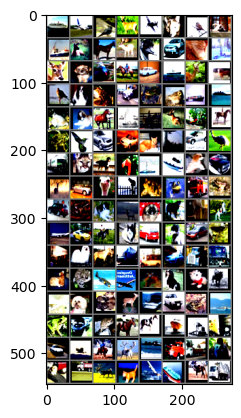

 ship airplane  bird  deer


In [11]:
# Function to show an image.
def imshow(img):
    img = img / 2 + 0.5 # unnormalize (reverse normalization).
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() # display the image using matplotlib.

# Get some random training images.
dataiter = iter(trainloader) # create an iterator from the training DataLoader
images, labels = next(dataiter)  # use the next function.

# Show images.
imshow(torchvision.utils.make_grid(images))

# Print labels.
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Model Architecture
- Design a CNN suitable for CIFAR-10 classification.

In [13]:
class Net(nn.Module):  # initialize the CNN model architecture.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x): # forward pass of the CNN model.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# Instantiate the CNN model
net = Net()

3. Model Training
- Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
- Utilize techniques such as early stopping to prevent overfitting.

In [15]:
import torch
from torch.backends import mps
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tabulate import tabulate
from tqdm import tqdm

# Check available device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_info = "GPU acceleration in place powered by nVIDIA (CUDA)"
elif mps.is_available():
    device = torch.device("mps")
    device_info = "GPU acceleration in place powered by Apple's Metal Performance Shaders (MPS)"
else:
    device = torch.device("cpu")
    device_info = "Using CPU... Best of luck..."

print("Training the Model")
print(device_info)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

# Load a pre-trained ResNet model
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 10)  # Assuming CIFAR-10 with 10 classes

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

# Move model and data to device if available
resnet.to(device)

# Training loop with tqdm progress bar
num_epochs = 10
training_metrics = []
validation_accuracies = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    trainloader_with_progress = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True)

    for i, data in enumerate(trainloader_with_progress, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        trainloader_with_progress.set_postfix(loss=running_loss / (i + 1))  # Update progress bar with current loss

    # Store training metrics
    train_loss = running_loss / len(trainloader)
    training_metrics.append(train_loss)

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(valloader, resnet)
    validation_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1} Validation Accuracy: {val_accuracy:.4f}")

print('Finished Training')

# Prepare data for tabulate
table_data = [
    ["Training Loss (Avg)", sum(training_metrics) / len(training_metrics)],
    ["Validation Accuracy (Last Epoch)", validation_accuracies[-1]]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="pretty"))


Training the Model
GPU acceleration in place powered by Apple's Metal Performance Shaders (MPS)
Files already downloaded and verified
Files already downloaded and verified


/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 1563/1563 [10:23<00:00,  2.51it/s, loss=0.663]


Epoch 1 Validation Accuracy: 0.8341


Epoch 2/10: 100%|██████████| 1563/1563 [10:16<00:00,  2.53it/s, loss=0.395]


Epoch 2 Validation Accuracy: 0.8685


Epoch 3/10: 100%|██████████| 1563/1563 [10:21<00:00,  2.51it/s, loss=0.285]


Epoch 3 Validation Accuracy: 0.8952


Epoch 4/10: 100%|██████████| 1563/1563 [10:23<00:00,  2.51it/s, loss=0.212]


Epoch 4 Validation Accuracy: 0.8824


Epoch 5/10: 100%|██████████| 1563/1563 [10:22<00:00,  2.51it/s, loss=0.157]


Epoch 5 Validation Accuracy: 0.9001


Epoch 6/10: 100%|██████████| 1563/1563 [10:14<00:00,  2.55it/s, loss=0.12] 


Epoch 6 Validation Accuracy: 0.8904


Epoch 7/10: 100%|██████████| 1563/1563 [10:09<00:00,  2.56it/s, loss=0.0977]


Epoch 7 Validation Accuracy: 0.8934


Epoch 8/10: 100%|██████████| 1563/1563 [10:16<00:00,  2.53it/s, loss=0.0794]


Epoch 8 Validation Accuracy: 0.8924


Epoch 9/10: 100%|██████████| 1563/1563 [10:20<00:00,  2.52it/s, loss=0.0707]


Epoch 9 Validation Accuracy: 0.8969


Epoch 10/10: 100%|██████████| 1563/1563 [10:17<00:00,  2.53it/s, loss=0.0573]


Epoch 10 Validation Accuracy: 0.9033
Finished Training
+----------------------------------+--------------------+
|              Metric              |       Value        |
+----------------------------------+--------------------+
|       Training Loss (Avg)        | 0.2137988117804707 |
| Validation Accuracy (Last Epoch) |       0.9033       |
+----------------------------------+--------------------+


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Prepare data for tabulate
extra_table_data = [
    ["Precision", f"{precision:.4f}"],
    ["Recall", f"{recall:.4f}"],
    ["F1 Score", f"{f1:.4f}"]
]

# Print the updated table
print(tabulate(extra_table_data, headers="firstrow", tablefmt="pretty"))

4. Model Evaluation
- Evaluate the trained model on the test set.
- Compute metrics: accuracy, precision, recall, F1-score.
- Visualize the confusion matrix.

+-----------+---------------------+
|  Metric   |        Value        |
+-----------+---------------------+
| Accuracy  |       0.1036        |
| Precision | 0.07305433837916744 |
|  Recall   | 0.10359999999999998 |
| F1 Score  | 0.03213393578826959 |
+-----------+---------------------+


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


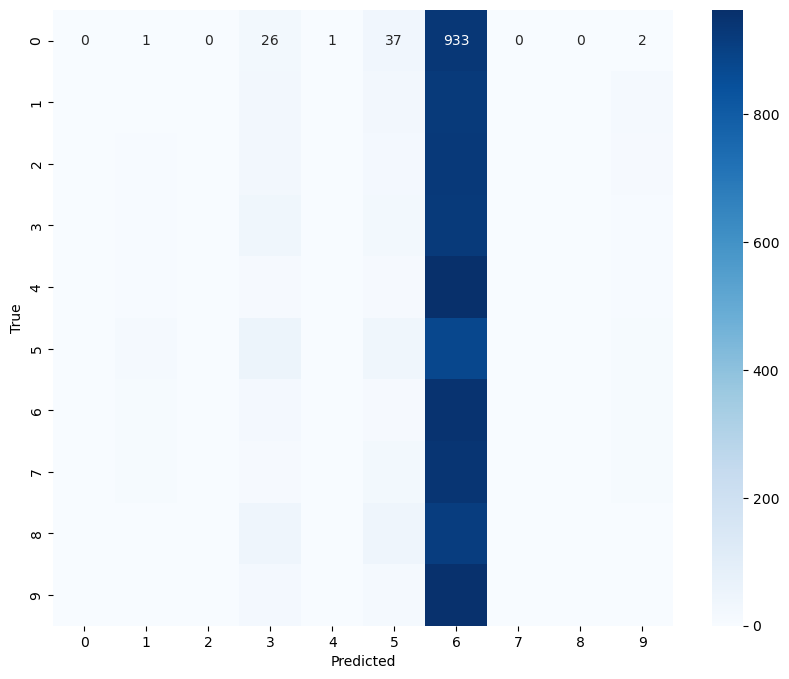

In [17]:
net.eval() # set the model to evaluation mode.

y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Calculate metrics.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# y_true and y_pred are already defined.
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Prepare the data for tabulate.
table = [["Accuracy", accuracy],
         ["Precision", precision],
         ["Recall", recall],
         ["F1 Score", f1]]

# Print the table.
print(tabulate(table, headers=["Metric", "Value"], tablefmt="pretty"))

# Confusion matrix.
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The End